In [1]:
import numpy as np

import sys

sys.path.append('../src')

import warnings
warnings.filterwarnings("ignore")

### Test focal region similarity

In [2]:
from Classes.experimental import FocalRegion

In [12]:
region = np.array([[1, 0], [0, 1]])
fra = FocalRegion(region)
fra.debug = True

history = np.array([[1, 0], [0, 1]])
print('History:\n', history)
print('-'*60)
scores = fra.get_similarity_scores(history)
print('Scores:\n', scores)
print('-'*60)








History:
 [[1 0]
 [0 1]]
------------------------------------------------------------
Cicle from column 0:
[[1 0]
 [0 1]]
Similarity score: 1.0
Cicle from column 1:
[[0 1]
 [1 0]]
Similarity score: 0.0
Scores:
 [1.0, 0.0]
------------------------------------------------------------


### Test FRA agents

In [4]:
from Classes.bar import Bar
from Utils.interaction import Episode
from Classes.experimental import FocalRegionAgent, SetFocalRegions

In [5]:
free_parameters = {
    'inverse_temperature': 10,
    'len_history': 2
}
fixed_parameters = {
    'num_agents': 7,
    'threshold': 0.7,
    'max_regions': 5
}
n = 1

In [6]:
# Create the environment
bar = Bar(
    num_agents=fixed_parameters['num_agents'],
    threshold=fixed_parameters['threshold']
)
# Create the agents
agents = [FocalRegionAgent(free_parameters, fixed_parameters, n) for n in range(fixed_parameters['num_agents'])]
# Create the episode
episode = Episode(
    model='FRA',
    agents=agents,
    environment=bar,
    num_rounds=20
)

In [7]:
print('Focal regions:')
print(episode.agents[0].sfr)

Focal regions:
------------------------------------------------------------
[[0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1.]]
------------------------------------------------------------------------------------------------------------------------
[[0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 1.]
 [0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1.]]
------------------------------------------------------------------------------------------------------------------------
[[0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 1. 1.]]
------------------------------------------------------------------------------------------------------------------------
[[0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 1.]
 [0. 1

In [8]:
# episode.agents[0].debug = True
# episode.agents[1].debug = True
episode.run()

<Axes: >

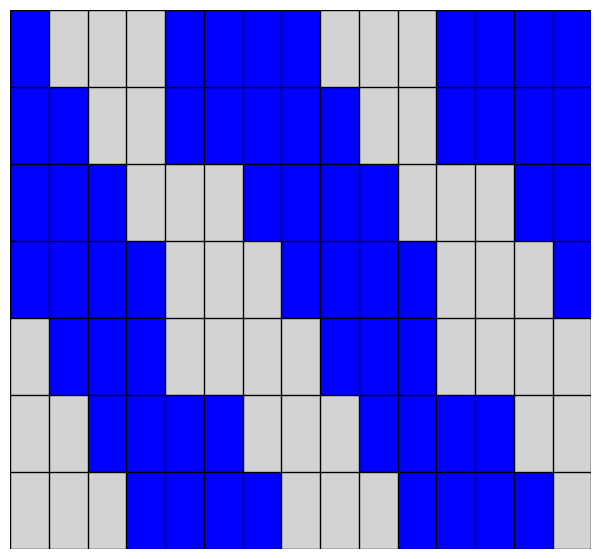

In [9]:
bar.render()